# SARFish dataset demo

This jupyter notebook is designed to show new users how to get working with the SARFish dataset as quickly as possible.

In [2]:
from pathlib import Path
import os
from time import time

import numpy as np # np.__version__ = 1.26.4 (had to downgrade to version < 2.0)
import pandas as pd
import matplotlib.pyplot as plt # Added by PJM
import yaml
from GeoTiff import load_GeoTiff

%gui qt
from visualise_labels import scale_sentinel_1_image, SARFish_Plot
from SARFish_metric import score

import sar_stats # added pb PJM

rng = np.random.default_rng(1234)

pd.set_option('display.max_columns', None)

ModuleNotFoundError: No module named 'GeoTiff'

## Quick Links

The following are links to the Kaggle competitions for each of the tracks of the SARFish challenge along with the SARFish dataset and GitHub repo:

- Data:
    - [SARFish](https://huggingface.co/datasets/ConnorLuckettDSTG/SARFish)
    - [SARFishSample](https://huggingface.co/datasets/ConnorLuckettDSTG/SARFishSample)
- [Labels](https://iuu.xview.us/download-links)
- Challenge:
    - [Maritime Object Detection Track](https://www.kaggle.com/competitions/sarfish-maritime-object-detection) 
    - [Maritime Object Classification Track](https://www.kaggle.com/competitions/sarfish-maritime-object-classification)
    - [Vessel Length Regression Track](https://www.kaggle.com/competitions/sarfish-vessel-length-regression)
- [GitHub repo](https://github.com/RitwikGupta/SARFish)
- [Mailbox](SARFish.Dataset@defence.gov.au)
- [DAIRNet](https://www.dairnet.com.au/events/workshop-on-complex-valued-deep-learning-and-sarfish-challenge/)

## What you will learn

1. What is the SARFish Challenge?
2. What is the SARFish dataset?
3. How to access the SARFish dataset
4. Dataset structure
5. How to load and visualise the SARFish imagery data
6. How to load and visualise the SARFish groundtruth labels
7. How to train, validate and test the reference/baseline model
8. SARFish challenge prediction submission format
9. How to evaluate model performance using the SARFish metric

## 1. What is the SARFish Challenge?

The SARFish challenge aims to develop deep learning models for the detection, classification and length estimation of maritime objects in complex-valued [Single Look Complex (SLC)](https://sentinels.copernicus.eu/web/sentinel/technical-guides/sentinel-1-sar/products-algorithms/level-1-algorithms/single-look-complex) [Synthetic Aperture Radar (SAR)](https://sentinel.esa.int/web/sentinel/missions/sentinel-1/instrument-payload) imagery data for the purpose of monitoring the activities of “dark” vessels engaged in [Illegal Unreported and Unregulated (IUU) fishing](https://globalfishingwatch.org/fisheries/iuu-illegal-unreported-unregulated-fishing/) practices. The SARFish challenge is inspired by the [xView3-SAR challenge](https://www.diu.mil/ai-xview-challenge) [2] which was released by [Global Fishing Watch (GFW)](https://globalfishingwatch.org/) and the [Defence Innovation Unit (DIU)](https://www.diu.mil/) in 2021 and adopts it's labels and performance metrics.

IUU fishing is a global problem with severe ecological, economic, and political impacts. It primarily affects developing nations, many of which rely on regional fisheries as a major source of food and income. Maritime surveillance of fishing activities is a challenging task. First, the scale of the problem is staggering; in 2009, the extent of IUU fishing was estimated to constitute 20% of the world’s catch or between 11 and 26 million metric tons. Another challenge is the presence of dark vessels, so called because they disable their Automatic Identification Systems (AIS) broadcasts in “disabling events” to avoid reporting obligations and obscure their illicit activities. One solution to the problem of tracking dark vessels is to detect ships automatically from satellite imagery. SAR is an active imaging system that provides worldwide day-night and all-weather coverage of littoral regions suited to the task.

[1]. Tri-Tan Cao, Connor Luckett, Jerome Williams, Tristrom Cooke, Ben Yip, Arvind Rajagopalan, and Sebastien Wong. Sarfish: Space-based maritime surveillance using complex synthetic aperture radar imagery. In 2022 International Conference on Digital Image Computing: Techniques and Applications (DICTA), pages 1–8. IEEE, 2022.

[2] xview3-sar: Detecting dark fishing activity using synthetic aperture radar imagery. arXiv:2206.00897v4 [cs.CV], Nov 2022.

### 1.2 Challenge Tracks

The SARFish challenge is divided into 3 tracks intended to align with the major challenges associated with the Monitoring, Control and Surveillance (MCS) of dark vessels:

#### [Maritime Object Detection](https://www.kaggle.com/competitions/sarfish-maritime-object-detection)

**Objective**: Locate maritime objects such as fishing vessels, oil rigs and offshore wind turbines in SARFish SLC imagery products. This track includes a close-to-shore detection task to assess model performance in the challenging task of detecting maritime objects within 2km of shorelines.

#### [Maritime Object Classification](https://www.kaggle.com/competitions/sarfish-maritime-object-classification)

**Objective**: Classify maritime objects as to whether or not they are vessels, and vessels as to whether or not they are fishing vessels. 

### [Vessel Length Regression](https://www.kaggle.com/competitions/sarfish-vessel-length-regression)

**Objective**: Predict the length of vessels.

### 1.3 How to participate

1. Download the SARFish dataset
2. Use the train and validation partitions of the SARFish dataset to generate your model.
3. Run inference over the entire public data partition outputing your predictions in submission format. 
4. Submit your predictions in csv format to the challenge track you wish to compete in.

## 2. What is the SARFish dataset?

### 2.1 Overview

SARFish is an imagery dataset for the purpose of training, validating and testing supervised machine learning models on the tasks of ship detection, classification and vessel length regression. SARFish builds on the excellent work of the [xView3-SAR dataset](https://iuu.xview.us/dataset) by expanding the imagery data to include [Single Look Complex (SLC)](https://sentinels.copernicus.eu/web/sentinel/technical-guides/sentinel-1-sar/products-algorithms/level-1-algorithms/single-look-complex) as well as [Ground Range Detected (GRD)](https://sentinels.copernicus.eu/web/sentinel/technical-guides/sentinel-1-sar/products-algorithms/level-1-algorithms/ground-range-detected) imagery data taken directly from the European Space Agency 
(ESA) Copernicus Programme [Open Access Hub Website](https://scihub.copernicus.eu/).

The following image shows a summarised description of the Sentinel-1 product family for the Interferrometric Wide (IW) mode. [^1] ![Sentinel-1 product processing pipeline summary](./images/sentinel_1_data_product_processing_levels_summary.jpg)

[^1]: G. Hajduch, M. Bourbigot, H. Johnsen, and R. Piantanida, Sentinel-1 Product Specification. Sentinel-1 Mission Performance Centre, 2022, p. 34. [Online]. Available: [https://sentinel.esa.int/web/sentinel/user-guides/sentinel-1-sar/document-library/-/asset_publisher/1dO7RF5fJMbd/content/id/4762447](https://sentinel.esa.int/web/sentinel/user-guides/sentinel-1-sar/document-library/-/asset_publisher/1dO7RF5fJMbd/content/id/4762447)

### 2.2 The Sentinel-1 processing pipeline

The following diagram shows how the SARFish dataset extends the xView3-SAR dataset by providing the minimally pre-processed GRD and SLC counterparts to the xView3-SAR dataset imagery products and provides labels which have been re-projected labels into the pixel space of the images. ![Relationship between the xView3-SAR and SARFish datasets](./images/xView3-SAR_SARFish_dataset_relation.jpg)

### 2.3 Minimal SARFish processing

The preprocessing applied to the Sentinel-1 images to create the SARFish dataset was chosen in order to be minimally invasive. The preprocessing of the xView3-SAR dataset included radiometric calibration, decibel scaling, range doppler geocoding, projection to UTM using the [SeNtinel Application Platform (SNAP)](https://earth.esa.int/eogateway/tools/snap) [Graph Processing Tool](https://seadas.gsfc.nasa.gov/help-8.3.0/gpf/GraphProcessingTool.html). In contrast, the only operations applied to the SARFish data have been those necesary to make the images usable for computer vison tasks. The philosophy was to provide GRD and SLC data in a format as close as practicable to the Sentinel-1 data that can be downloaded from Copernicus.

| Operation | xView3-SAR dataset | SARFish dataset |
|-----------|--------------------|-----------------|
| [radiometric-calibration](https://sentinels.copernicus.eu/web/sentinel/radiometric-calibration-of-level-1-products) | True | False |
| [decibel scaling](https://en.wikipedia.org/wiki/Decibel) | True | False |
| [range dopper geocoding](https://sentinel.esa.int/documents/247904/1653442/Guide-to-Sentinel-1-Geocoding.pdf)  | True | False |
| [projection to UTM](https://en.wikipedia.org/wiki/Universal_Transverse_Mercator_coordinate_system) | True | False |
| flipping | True | True |
| [de-bursting](https://sentinels.copernicus.eu/web/sentinel/level-1-post-processing-algorithms) | True | True |
| [no data masking](https://gdal.org/development/rfc/rfc15_nodatabitmask.html) | True | True  |

### Flipping:

Flipping is applied to both GRD and SLC products. Sentinel-1 images are reflected with respect to the Earth's surface. This is due to the data aquisition method; first sensed azimuth lines are placed in the first rows in the image array. Images from both ascending and descending orbits will not map to the Earth's surface with a rotation, necessitating a flip along one axis. The images and ground control points (GCPS) are reversed along the range/x axis. 

### Debursting

Debursting is applied only to SLC products. Sentinel-1 SLC products are provided as sets of 3 "swaths" per channel per scene. These swaths consist of "sub-swaths" or "bursts" which are overlapping segments of the image. The process of de-bursting is the alignment of these bursts into a contiguous image. This was done to create a one-to-one correspondence between the objects in each swath and the features on the Earth to which they correspond. It is important to note that as the deburst images are concatenations of bursts which themselves are individual SAR images, there are significant phase discontinuities on the boundaries of the bursts. It was decided for the purposes of this dataset that the bursts within the individual swaths should be merged rather than being split into seperate images.

### No data masking

No data masking is applied to both GRD and SLC products. Invalid pixels in the image have been masked using a nodata mask.

## 3. Accessing the data

### 3.1 Downloading data from huggingface

The SARFish dataset is available for download at:
- [full SARFish dataset](https://huggingface.co/datasets/ConnorLuckettDSTG/SARFish)
- [sample SARFish dataset](https://huggingface.co/datasets/ConnorLuckettDSTG/SARFishSample)

| dataset       | coincident GRD, SLC products | compressed (GB) | uncompressed (GB) |
| ------------- | ---------------------------- | --------------- | ----------------- |
| SARFishSample | 1                            | 4.3             | 8.2               |
| SARFish       | 753                          | 3293            | 6468              |

#### Full SARFish dataset

Make sure you have at least enough storage space for the uncompressed dataset.

```bash
cd /path/to/large/storage/location
```

[Create|login] to a [huggingface](https://huggingface.co) account.

Login to the huggingface command line interface.

```bash
huggingface-cli login
```

Copy the access token in settings/Access Tokens from your huggingface account. Clone the dataset

```bash
git lfs install
git clone https://huggingface.co/datasets/ConnorLuckettDSTG/SARFish
```

#### SARFish sample dataset

Substitute the final command for the full dataset with the following:

```bash
git clone https://huggingface.co/datasets/ConnorLuckettDSTG/SARFishSample
```

### 3.2 Checking the md5sums

Use the provided sum checking functionn to check the md5 sums of the downloaded SARFish products

```bash
./check_SARFish_md5sum.py
```

### 3.3 Unizipping the data

Use the provided unzipping function to unzip the SARFish data products in parallel.

```bash
cd /path/to/SARFish/directory/GRD
unzip\_batch.sh -p $(find './' -type f -name "*.SAFE.zip")

cd /path/to/SARFish/directory/SLC
unzip\_batch.sh -p $(find './' -type f -name "*.SAFE.zip")
```

### 3.4 Setting the SARFish dataset root directory.

Modify the environment.yaml file in this directory and substitude the dummy path with the SARFish root directory. For example; if your local copy of the SARFish dataset resides in /data/SARFish, subsitute /path/to/SARFish/root/ with /data/.

```
SARFISH_ROOT_DIRECTORY: /path/to/SARFish/root/ 
```

In [ ]:
with open("environment.yaml", "r") as f:
    environment = yaml.safe_load(f)

SARFish_root_directory = environment['SARFish_root_directory']
os.environ['SARFISH_ROOT_DIRECTORY'] = SARFish_root_directory

The SARFish dataset is packaged in the [SAFE format](https://sentinels.copernicus.eu/web/sentinel/user-guides/sentinel-1-sar/data-formats/safe-specification). The product file name consists of the unique [product identifier](https://sentinel.esa.int/documents/247904/1877131/Sentinel-1-Product-Specification) (section 3.5.1) from which the SARFish product was derived.

The following tree shows an overview of the SARFish dataset:

```
SARFish/
├── GRD
│   ├── public
│   │   └── S1B_IW_GRDH_1SDV_*.SAFE
│   ├── train
│   │   └── S1B_IW_GRDH_1SDV_*.SAFE
│   └── validation
│       └── S1B_IW_GRDH_1SDV_*.SAFE
└── SLC
    ├── public
    │   └── S1B_IW_SLC__1SDV_*.SAFE
    ├── train
    │   └── S1B_IW_SLC__1SDV_*.SAFE
    └── validation
        └── S1B_IW_SLC__1SDV_*.SAFE
```

## 4. Dataset Structure

### 4.1 Dataset Partitions

The partitions of the dataset are as follows:

| partition   | labels provided |
| ----------- | --------------- |
| train       | True            |
| validation  | True            |
| public      | False           |

The public partition is provided with no labels. It will to be used to determine competitor's ranking in the SARFish challenge. Competitors will run their model over the public partition of the dataset producing predictions for each constituent scene and submit these in the submisson format (see section 6)

### 4.2 The two SARFish product types: GRD and SLC

The SARFish dataset consists of pairs of coincident [real-valued GRD and complex valued SLC](https://sentinels.copernicus.eu/web/sentinel/user-guides/sentinel-1-sar/product-types-processing-levels/level-1) imagery products from the Sentinel-1 satellite constellation. The GRD and SLC designations are the **product\_type**. The mapping between xView3-SAR **scene\_id** and the [Copernicus](https://www.copernicus.eu/en) product identifier is contained in the xView3\_SLC\_GRD\_correspondences.csv file. The following cell shows an example of the mapping between xView3-SAR and SARFish GRD, SLC products.

In [4]:
xView3_SLC_GRD_correspondences = pd.read_csv("~/CITS5014/SARFish/reference/labels/xView3_SLC_GRD_correspondences.csv")
xView3_SLC_GRD_correspondences[['scene_id', 'GRD_product_identifier', 'SLC_product_identifier']].iloc[703:704] # PJM: the scene contained in the SARFishSample dataset

,scene_id,GRD_product_identifier,SLC_product_identifier
703,5c3d986db930f848v,S1B_IW_GRDH_1SDV_20200803T075721_20200803T0757...,S1B_IW_SLC__1SDV_20200803T075720_20200803T0757...


The xView3\_SLC\_GRD\_correspondences.csv file also contains the file names of the vh, vh imagery products and their associated annotation.xml files. This is used to pick out individual imagery data for processing and evalutation.

In [5]:
xView3_SLC_GRD_correspondences.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 753 entries, 0 to 752
Data columns (total 22 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   DATA_PARTITION             753 non-null    object
 1   scene_id                   753 non-null    object
 2   GRD_product_identifier     753 non-null    object
 3   GRD_md5sum                 753 non-null    object
 4   GRD_vh                     753 non-null    object
 5   GRD_vv                     753 non-null    object
 6   GRD_vh_annotation          753 non-null    object
 7   GRD_vv_annotation          753 non-null    object
 8   SLC_product_identifier     753 non-null    object
 9   SLC_md5sum                 753 non-null    object
 10  SLC_swath_1_vh             753 non-null    object
 11  SLC_swath_1_vv             753 non-null    object
 12  SLC_swath_1_vh_annotation  753 non-null    object
 13  SLC_swath_1_vv_annotation  753 non-null    object
 14  SLC_swath_

### 4.3 SARFish dataset format

#### GRD imagery

GRD products are uniquely identified by their:

- product\_type
- partition 
- GRD\_product\_identifier
- polarisation 

The tree of an example SARFish GRD Product:

```
SARFish/GRD/validation/S1B_IW_GRDH_1SDV_20201013T054010_20201013T054035_023790_02D350_506A.SAFE/
├── annotation
│   └── ...
├── manifest.safe
├── measurement <- imagery data
│   ├── S1B_IW_GRDH_1SDV_20201013T054010_20201013T054035_023790_02D350_506A_global_shoreline_vector.npy
│   ├── S1B_IW_GRDH_1SDV_20201013T054010_20201013T054035_023790_02D350_506A_xView3_shoreline.npy
│   ├── s1b-iw-grd-vh-20201013t054010-20201013t054035-023790-02d350-002_SARFish.tiff
│   └── s1b-iw-grd-vv-20201013t054010-20201013t054035-023790-02d350-001_SARFish.tiff
├── preview
│   └── ...
├── ...
└── support
    └── ...
```

The imagery data located in "measurement" consists of 2 images containing the polarimetic channels called VV, VH polarisations packaged in the GeoTiff format. Also included in the measurement folder are numpy archives which contain shoreline vectors which are used in the evaluation of a model's close-to-shore detection performance.

#### SLC imagery

SLC products are uniquely identified by their:

- product\_type
- partition 
- GRD\_product\_identifier
- polarisation
- swath\_index

The tree of an example SARFish SLC Product:

```
SARFish/SLC/validation/S1B_IW_SLC__1SDV_20201013T054008_20201013T054035_023790_02D350_04D0.SAFE
├── annotation
│   └── ...
├── manifest.safe
├── measurement
│   ├── s1b-iw1-slc-vh-20201013t054009-20201013t054034-023790-02d350-001_SARFish.tiff                 <- swath 1 SLC VH-polarisation image
│   ├── s1b-iw1-slc-vh-20201013t054009-20201013t054034-023790-02d350-001_SARFish.tiff.msk             
│   ├── s1b-iw1-slc-vv-20201013t054009-20201013t054034-023790-02d350-004_SARFish.tiff                 <- swath 1 SLC VV-polarisation image
│   ├── s1b-iw1-slc-vv-20201013t054009-20201013t054034-023790-02d350-004_SARFish.tiff.msk
│   ├── s1b-iw2-slc-vh-20201013t054010-20201013t054035-023790-02d350-002_SARFish.tiff                 <- swath 2 SLC VH-polarisation image
│   ├── s1b-iw2-slc-vh-20201013t054010-20201013t054035-023790-02d350-002_SARFish.tiff.msk
│   ├── s1b-iw2-slc-vv-20201013t054010-20201013t054035-023790-02d350-005_SARFish.tiff                 <- swath 2 SLC VV-polarisation image
│   ├── s1b-iw2-slc-vv-20201013t054010-20201013t054035-023790-02d350-005_SARFish.tiff.msk
│   ├── s1b-iw3-slc-vh-20201013t054008-20201013t054033-023790-02d350-003_SARFish.tiff                 <- swath 3 SLC VH-polarisation image
│   ├── s1b-iw3-slc-vh-20201013t054008-20201013t054033-023790-02d350-003_SARFish.tiff.msk
│   ├── s1b-iw3-slc-vv-20201013t054008-20201013t054033-023790-02d350-006_SARFish.tiff                 <- swath 3 SLC VV-polarisation image
│   ├── s1b-iw3-slc-vv-20201013t054008-20201013t054033-023790-02d350-006_SARFish.tiff.msk
│   ├── S1B_IW_SLC__1SDV_20201013T054008_20201013T054035_023790_02D350_04D0_1_global_shoreline_vector.npy  <- swath 1 global shoreline vector
│   ├── S1B_IW_SLC__1SDV_20201013T054008_20201013T054035_023790_02D350_04D0_1_xView3_shoreline.npy         <- swath 1 xView3 shoreline vector
│   ├── S1B_IW_SLC__1SDV_20201013T054008_20201013T054035_023790_02D350_04D0_2_global_shoreline_vector.npy
│   ├── S1B_IW_SLC__1SDV_20201013T054008_20201013T054035_023790_02D350_04D0_2_xView3_shoreline.npy
│   ├── S1B_IW_SLC__1SDV_20201013T054008_20201013T054035_023790_02D350_04D0_3_global_shoreline_vector.npy
│   └── S1B_IW_SLC__1SDV_20201013T054008_20201013T054035_023790_02D350_04D0_3_xView3_shoreline.npy
├── preview
│   └── ...
├── ...
└── support
    └── ...
```

The imagery data located in the "measurement" directory consists of 3 sets (swaths) of 2 images containing the polarimetric channels called VV, VH packaged in the GeoTiff. Each Sentinel-1 SLC product is the composite of 3 swaths. The process of [debursting](https://github.com/senbox-org/s1tbx/blob/master/s1tbx-op-sentinel1-ui/src/main/resources/org/esa/s1tbx/sentinel1/docs/operators/TOPSARDeburstOp.html) has been applied to each swath, but the swaths have not been merged. Each SLC swath is again accompanied by a corresponding xView3-SAR and global shoreline vector. In addition corresponding [.msk](https://gdal.org/development/rfc/rfc15_nodatabitmask.html) (mask) files are used by the GeoTiff.load\_Geotiff function in order to mask the no-data portions of the SLC products. The function load_Geotiff allow a user to easily load both GRD and SLC SARFish products taking into account their respective masks.

## 5. How to load and visualise the SARFish imagery data

To generate the path to the GRD and SLC products associated with a single scene, we first we pick out a specific row from the xView3_SLC_GRD_correspondence table:

In [6]:
# PJM: The following extracts the validation partition row entries from the xView3_SLC_GRD_correspondences.csv file
# PJM: and stores them in a pandas Series named 'correspondence'
# PJM: squeeze() method converts extracted df row into a Series (simplifies indexing)
correspondence = xView3_SLC_GRD_correspondences.iloc[703:704].squeeze() 
correspondence

DATA_PARTITION                                                      validation
scene_id                                                     5c3d986db930f848v
GRD_product_identifier       S1B_IW_GRDH_1SDV_20200803T075721_20200803T0757...
GRD_md5sum                                    3f8ec460304f087c8f9a59b7c0897561
GRD_vh                       s1b-iw-grd-vh-20200803t075721-20200803t075746-...
GRD_vv                       s1b-iw-grd-vv-20200803t075721-20200803t075746-...
GRD_vh_annotation            s1b-iw-grd-vh-20200803t075721-20200803t075746-...
GRD_vv_annotation            s1b-iw-grd-vv-20200803t075721-20200803t075746-...
SLC_product_identifier       S1B_IW_SLC__1SDV_20200803T075720_20200803T0757...
SLC_md5sum                                    c32f40b7d3a1304a30c287d7eae75684
SLC_swath_1_vh               s1b-iw1-slc-vh-20200803t075720-20200803t075748...
SLC_swath_1_vv               s1b-iw1-slc-vv-20200803t075720-20200803t075748...
SLC_swath_1_vh_annotation    s1b-iw1-slc-vh-20200803

### 5.1 Loading GRD imagery

The correspondence mapping is used to generate the specific GRD product path.

In [6]:
# PJM: Loads GRD (VH polarisation) Geotiff from SARFishSample dataset 
measurement_path_GRD = Path(SARFish_root_directory, "GRD", correspondence['DATA_PARTITION'], f"{correspondence['GRD_product_identifier']}.SAFE",
                            "measurement", correspondence[f'GRD_vh'])
str(measurement_path_GRD)

'/home/peterm/UWA/CITS5014/data/SARFishSample/GRD/validation/S1B_IW_GRDH_1SDV_20200803T075721_20200803T075746_022756_02B2FF_033A.SAFE/measurement/s1b-iw-grd-vh-20200803t075721-20200803t075746-022756-02b2ff-002_SARFish.tiff'

The image is loaded into numpy arrays using the provided GeoTiff.load_Geotiff function. The function returns an array of image data, and a second array masking the no data areas. Since the data is in linear scale, we use the provided scaling function visualise\_labels.scale_sentinel\_1\_image to convert the data to a decibel scale which is more easily interpereted by humans.

In [7]:
data_GRD, nodata_mask_GRD, nodata_value, _ = load_GeoTiff(str(measurement_path_GRD))

In [8]:
# PJM: Get some information about the arrays extracted
print(f"data_GRD:\t type = {type(data_GRD)}, dtype = {data_GRD.dtype}")
print(f"nodata_mask_GRD: type = {type(nodata_mask_GRD)}, dtype = {nodata_mask_GRD.dtype}")
print(f"nodata_value: {nodata_value}")

data_GRD:	 type = <class 'numpy.ndarray'>, dtype = uint16
nodata_mask_GRD: type = <class 'numpy.ndarray'>, dtype = bool
nodata_value: 0.0


In [11]:
# PJM: Stats on raw GRD
GRD_stats_raw = sar_stats.array_stats(data_GRD)
print(GRD_stats_raw)

{'min': 0, 'max': 8061, 'nan_count': 0, 'valid_count': 421193064, 'total_count': 421193064, 'shape': (16644, 25306)}


In [12]:
# PJM: Stats on associated nodata mask
stats = sar_stats.boolean_mask_stats(nodata_mask_GRD)
print(stats)

{'true_count': 2774538, 'false_count': 418418526, 'total_count': 421193064, 'true_percentage': 0.6587330697354504, 'shape': (16644, 25306), 'all_true': False, 'any_true': True, 'all_false': False}


**Note that nodata_mask_GRD is a very sparse mask with only 0.66% True values**)

In [13]:
scaled_data_GRD = scale_sentinel_1_image(data_GRD, nodata_mask_GRD, product_type = "GRD")
#data_GRD = None # frees up memory - no longer needed
clipped_scaled_data_GRD = np.clip(scaled_data_GRD, 10, 30)
#scaled_data_GRD = None # frees up memory - no longer needed

In [14]:
# PJM: Stats on clipped and scaled GRD 
GRD_stats_clipped_scaled = sar_stats.array_stats(clipped_scaled_data_GRD)
print(GRD_stats_clipped_scaled)

{'min': 10.0, 'max': 30.0, 'nan_count': 0, 'valid_count': 421193064, 'total_count': 421193064, 'shape': (16644, 25306)}


### 5.2 Plotting GRD imagery

The data can be plotted using the provided SARFish\_Plot class. 

**Need to downsample the image first...**

In [15]:
# PJM: sets a scale factor to donwsample image as it's large to display using VisPy
scale_factor = 2 # PJM: retain every other pixel

In [16]:
# PJM: Sample every scale_factor pixels in both dimensions before plotting using SARFish_plot
subsampled_clipped_scaled_data_GRD = clipped_scaled_data_GRD[::scale_factor, ::scale_factor]
subsampled_clipped_scaled_data_GRD.shape

(8322, 12653)

In [17]:
# PJM: Subsample the nodata_mask the same way
subsampled_nodata_mask_GRD = nodata_mask_GRD[::scale_factor, ::scale_factor]
subsampled_nodata_mask_GRD.shape

(8322, 12653)

In [18]:
sar_stats.boolean_mask_stats(subsampled_nodata_mask_GRD)

{'true_count': 693876,
 'false_count': 104604390,
 'total_count': 105298266,
 'true_percentage': 0.6589624182415311,
 'shape': (8322, 12653),
 'all_true': False,
 'any_true': True,
 'all_false': False}

**Note: in order for SARFish_Plot to work vi VisPy, I had to add "export LIBGL_ALWAYS_SOFTWARE=1" to SARFISH/venv/bin/activate** 

In [19]:
# PJM: Plot downsampled image
plot_GRD = SARFish_Plot(subsampled_clipped_scaled_data_GRD, subsampled_nodata_mask_GRD, title = f"Example GRD product (downsampled to {subsampled_nodata_mask_GRD.shape} pixels)"C)
#subsampled_clipped_scaled_data_GRD = None
#nodata_mask_GRD_resized = None

**Alternative method for downsampling:**

In [20]:
import cv2  # PJM: OpenCV for resizing

# cv2.resize():
#  - Shrinks or enlarges the image to fit the given new_size.
#  - Uses pixel area relation to prevent distortion when reducing size (better quality than other methods).
#  - Outputs a new NumPy array (data_resized) with the resized version of data.

new_size = (12653, 8322)  # downscaled image dimensions

data_resized = cv2.resize(clipped_scaled_data_GRD, new_size, interpolation=cv2.INTER_AREA)
nodata_mask_GRD_resized = cv2.resize(nodata_mask_GRD.astype(np.uint8), new_size, interpolation=cv2.INTER_NEAREST)

# Pass the resized images to the plot
plot_GRD = SARFish_Plot(data_resized, nodata_mask_GRD_resized, title=f"Example GRD product using cv2.resize() to downsample {new_size} pixels", show=True)

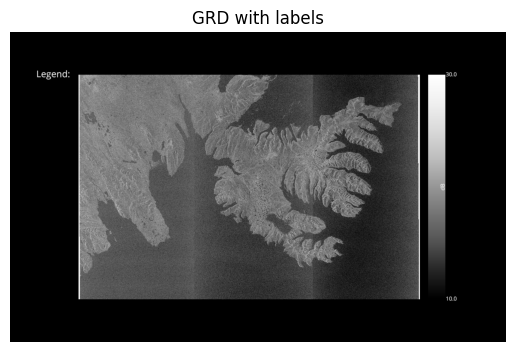

In [21]:
# PJM: Plot the same image inline using matplotlib
img = plot_GRD.render()  # Capture the VisPy canvas as an image
plt.title("GRD with labels")
plt.imshow(img)
plt.axis('off')
plt.show()

### 5.3 Plotting SLC imagery

There are three SLC swaths per product. We will load and visualise the imagery in one cell.

In [ ]:
# SLC_plots = []
# for swath_index in [1, 2, 3]:
#     start = time()
    
#     measurement_path_SLC = Path(
#         SARFish_root_directory, "SLC", correspondence['DATA_PARTITION'], f"{correspondence['SLC_product_identifier']}.SAFE",
#         "measurement", correspondence[f'SLC_swath_{swath_index}_vh']
#     )
    
#     data_SLC, nodata_mask_SLC, _, _ = load_GeoTiff(str(measurement_path_SLC))
#     scaled_data_SLC = scale_sentinel_1_image(data_SLC, nodata_mask_SLC, product_type = "SLC")
#     data_SLC = None
#     clipped_scaled_data_SLC = np.clip(scaled_data_SLC, 15, 60)
#     scaled_data_SLC = None
    
#     stop = time()
#     print(f"SLC swath {swath_index} loading time: {stop - start} seconds.")

#     plot_SLC = SARFish_Plot(
#         clipped_scaled_data_SLC, nodata_mask_SLC,
#         title = f"example plotting groundtruth labels in {correspondence['SLC_product_identifier']}, swath: {swath_index}"
#     )
#     SLC_plots.append(plot_SLC)
#     nodata_mask_SLC = None
#     clipped_scaled_data_SLC = None

In [22]:
# PJM: modified version of above; plots SARSample validatiosn SLC VH polarisation images (swaths 1, 2 and 3)
SLC_plots = []
for swath_index in [1, 2, 3]:
    start = time()
    
    measurement_path_SLC = Path(
        SARFish_root_directory, "SLC", correspondence['DATA_PARTITION'], f"{correspondence['SLC_product_identifier']}.SAFE",
        "measurement", correspondence[f'SLC_swath_{swath_index}_vh']
    )
    
    data_SLC, nodata_mask_SLC, _, _ = load_GeoTiff(str(measurement_path_SLC))
    print(f"data_SLC:\t type = {type(data_SLC)}, dtype = {data_SLC.dtype}, shape = {data_SLC.shape}")
    print(f"nodata_mask_SLC: type = {type(nodata_mask_SLC)}, dtype = {nodata_mask_SLC.dtype},\t    shape = {nodata_mask_SLC.shape}")
    print(f"nodata_value: {nodata_value}")
    scaled_data_SLC = scale_sentinel_1_image(data_SLC, nodata_mask_SLC, product_type = "SLC")
    data_SLC = None
    clipped_scaled_data_SLC = np.clip(scaled_data_SLC, 15, 60)
    scaled_data_SLC = None
    clipped_scaled_data_SLC_resized = clipped_scaled_data_SLC[::scale_factor, ::scale_factor]
    clipped_scaled_data_SLC = None
    nodata_mask_SLC_resized = nodata_mask_SLC[::scale_factor, ::scale_factor]
    
    stop = time()
    print(f"SLC swath {swath_index} loading time: {stop - start} seconds.\n")
#'''
    plot_SLC = SARFish_Plot(
        clipped_scaled_data_SLC_resized, nodata_mask_SLC_resized,
        title = f"Example SLC product (downsampled), swath: {swath_index}", show=True
    )
    SLC_plots.append(plot_SLC)
    nodata_mask_SLC_resized = None
    clipped_scaled_data_SLC_resized = None
#'''

data_SLC:	 type = <class 'numpy.ndarray'>, dtype = complex64, shape = (13573, 20595)
nodata_mask_SLC: type = <class 'numpy.ndarray'>, dtype = bool,	    shape = (13573, 20595)
nodata_value: 0.0
SLC swath 1 loading time: 5.698599338531494 seconds.

data_SLC:	 type = <class 'numpy.ndarray'>, dtype = complex64, shape = (12237, 24515)
nodata_mask_SLC: type = <class 'numpy.ndarray'>, dtype = bool,	    shape = (12237, 24515)
nodata_value: 0.0
SLC swath 2 loading time: 6.057565689086914 seconds.

data_SLC:	 type = <class 'numpy.ndarray'>, dtype = complex64, shape = (12248, 23701)
nodata_mask_SLC: type = <class 'numpy.ndarray'>, dtype = bool,	    shape = (12248, 23701)
nodata_value: 0.0
SLC swath 3 loading time: 5.3163580894470215 seconds.



In [23]:
SLC_plots

[<SARFish_Plot (PyQt5) at 0x7014ad0cafe0>,
 <SARFish_Plot (PyQt5) at 0x7013f051e7d0>,
 <SARFish_Plot (PyQt5) at 0x7013f01d6da0>]

**Examine the .msk file associated with the SARFishSample validation SLC VH polarisation product (swath 3)**

In [24]:
# PJM: construc the path to the .msk file
measurement_path_SLC_msk = Path(
        SARFish_root_directory, "SLC", correspondence['DATA_PARTITION'], f"{correspondence['SLC_product_identifier']}.SAFE",
        "measurement", "s1b-iw3-slc-vh-20200803t075722-20200803t075747-022756-02b2ff-003_SARFish.tiff.msk")

In [25]:
# PJM Check the file path
str(measurement_path_SLC_msk)

'/home/peterm/UWA/CITS5014/data/SARFishSample/SLC/validation/S1B_IW_SLC__1SDV_20200803T075720_20200803T075748_022756_02B2FF_E5D2.SAFE/measurement/s1b-iw3-slc-vh-20200803t075722-20200803t075747-022756-02b2ff-003_SARFish.tiff.msk'

In [26]:
# PJM: Load and examine the .msk file associated with the SLC VH polarisation product (swath 3)
nodata, _, _, _ = load_GeoTiff(str(measurement_path_SLC_msk))

In [27]:
nodata.dtype

dtype('uint8')

In [28]:
nodata_stats = sar_stats.array_stats(nodata)
print(nodata_stats)

{'min': 0, 'max': 255, 'nan_count': 0, 'valid_count': 290289848, 'total_count': 290289848, 'shape': (12248, 23701)}


In [29]:
# PJM: Subsample the nodata_mask by scale_factor in order to plot it
nodata = nodata[::scale_factor, ::scale_factor]
nodata.shape

(6124, 11851)

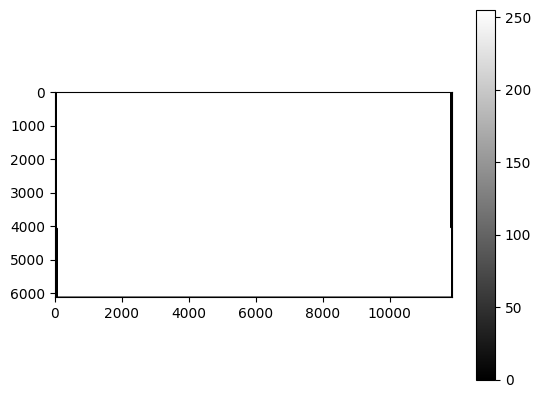

In [30]:
# PJM: plot the mask file
import matplotlib.pyplot as plt
plt.imshow(nodata, cmap='gray')
plt.colorbar()
plt.show()

PJM: Just the edges of the plot are masked as no data (black=0). Note that the nodata array is not a Boolean array.

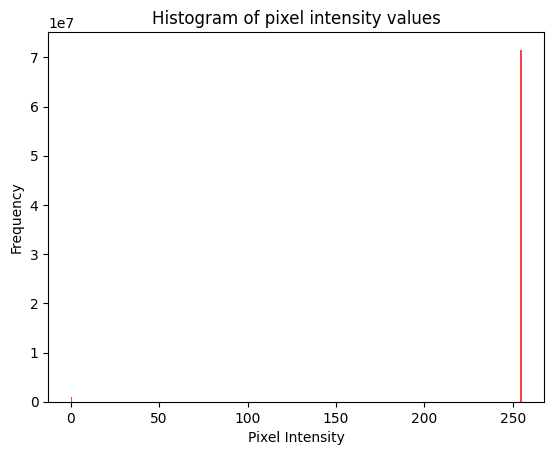

In [31]:
# PJM: Plot a histogram of the values in nodata

# Flatten the array to get the pixel intensity values
pixel_values = nodata.flatten()

# Plot the histogram
plt.hist(pixel_values, bins=256, range=(0, 255), color='red', alpha=0.75)
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')
plt.title('Histogram of pixel intensity values')
plt.show()

In [32]:
# PJM: this cell is included for my information only

import numpy as np

'''
A complex64 data type consists of two float32 numbers: one for the real part and one for the imaginary part.
This means each complex number in the array takes up 64 bits in total (32 bits for the real component and
32 bits for the imaginary component).
'''

arr = np.array([1+2j, 3+4j, 5+6j], dtype=np.complex64)
print(arr)
print(arr.dtype)

[1.+2.j 3.+4.j 5.+6.j]
complex64


## 6. How to load and visualise the SARFish labels

The groundtruth labels for the SARFish dataset are aranged similarly to the xView3-SAR dataset. The labels contain the location, classification and length of each maritime object present in all scenes for a particular product type and dataset partition.

### 6.1 Label Structure

#### Location labels

The labels denote the image pixel and geographic coordinate location of the maritime object.

| field     | data_type | description |
| --------- | ----------- | --------- |
| detect\_lat | float | latitude of detection in World Geodetic System (WGS) 84 coordinates |
| detect\_lon | float | longitude of detection in WGS84 coordinates |
| detect\_scene\_row | int | pixel row of scene containing detection |
| detect\_scene\_column | int | pixel column of scene containing detection |

#### Classification Labels

The labels for the maritime object classification are organised in the same hierarchical structure as the xView3-SAR challenge labels:

```bash
label_heirarchy:
└── maritime_objects
    └── vessels
        └── fishing_vessels
```

They are denoted by the following columns in the labels:

| field     | data_type | description |
| --------- | ----------- | --------- |
| is\_vessel | bool | True if detection is a vessel, False otherwise |
| is\_fishing | bool | True if detection is a fishing vessel, False otherwise |

The maritime object categories are labelled using boolean values to the following questions:

- is the maritime object a vessel?
- is the vessel a fishing vessel?

The following table shows the combinations of hierarchical classification labels present in the SARFish dataset:

| is\_vessel | is\_fishing |
|------------:|-------------:|
| False | nan |
| True | nan |
| | False |
| | True |
| nan | nan |

#### Vessel Length Labels

The vessel lengths are denoted in the following column in the labels:

| field     | data_type | description |
| --------- | ----------- | --------- |
| vessel\_length\_m | float | length of vessel in meters; only provided where available from AIS |

The full groundtruth label attributes are detailed in the table below.

| field     | data_type | description |
| --------- | ----------- | --------- |
| partition | str: \{"train", "validation"\} | split of the dataset |
| product\_type | str: \{"GRD", "SLC"\} | product type of the data |
| scene\_id | str | unique xView3 scene ID for challenge purposes |
| detect\_id | str | unique detection ID in format scene\_id\_detect\_lat\_detect\_lon |
| \{product\_type\}\_product\_identifier | str | The copernicus Sentinel-1 product identifier for the designated product type |
| detect\_lat | float | latitude of detection in World Geodetic System (WGS) 84 coordinates |
| detect\_lon | float | longitude of detection in WGS84 coordinates |
| detect\_scene\_row | int | pixel row of scene containing detection |
| detect\_scene\_column | int | pixel column of scene containing detection |
| top | float | pixel row of the top left corner of the bounding box, where available |
| left | float | pixel column of the top left corner of the bounding box, where available |
| bottom | float | pixel row of the bottom right corner of the bounding box, where available |
| right | float | pixel column of the bottom right corner of the bounding box, where available |
| vessel\_length\_m | float | length of vessel in meters; only provided where available from AIS |
| source | str: \{AIS, AIS/Manual, Manual\} | source of detection (AIS, manual label, or both) |
| is\_vessel | bool | True if detection is a vessel, False otherwise |
| is\_fishing | bool | True if detection is a fishing vessel, False otherwise |
| global\_shoreline\_vector\_distance\_from\_shore\_km | float | distance from shore of detection in kilometers as determined using the global shoreline vectors projected into the pixel space of the SARFish products  |
| xView3\_shoreline\_vector\_distance\_from\_shore\_km | float | distance from shore of detection in kilometers as determined using the  xView3-SAR shoreline vectors projected into the pixel space of the SARFish products  |
| confidence | str: \{HIGH, MEDIUM, LOW\} | level of confidence for is\_vessel and is\_fishing labels |

### 6.1 Loading and visualising GRD groundtruth labels

In [33]:
groundtruth_GRD = pd.read_csv(str(Path(SARFish_root_directory, "GRD", correspondence['DATA_PARTITION'], f"GRD_{correspondence['DATA_PARTITION']}.csv")))
groundtruth_GRD = groundtruth_GRD[groundtruth_GRD['GRD_product_identifier'] == correspondence['GRD_product_identifier']]

In [34]:
groundtruth_GRD.info()

<class 'pandas.core.frame.DataFrame'>
Index: 329 entries, 0 to 328
Data columns (total 20 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   partition                                       329 non-null    object 
 1   product_type                                    329 non-null    object 
 2   scene_id                                        329 non-null    object 
 3   detect_id                                       329 non-null    object 
 4   GRD_product_identifier                          329 non-null    object 
 5   detect_lat                                      329 non-null    float64
 6   detect_lon                                      329 non-null    float64
 7   detect_scene_column                             329 non-null    float64
 8   detect_scene_row                                329 non-null    float64
 9   top                                             

In [35]:
# PJM: Scale down the bounding box and target coordinates
groundtruth_GRD[['detect_scene_column', 'detect_scene_row', 'left', 'right', 'bottom', 'top']] = groundtruth_GRD[['detect_scene_column', 'detect_scene_row', 'left', 'right', 'bottom', 'top']].apply(lambda x: round(x / scale_factor))

In [36]:
# Add the bounding boxes to the existing plots
plot_GRD.add_bboxes(groundtruth_GRD[['left', 'right', 'bottom', 'top']])
plot_GRD.add_labels(columns = groundtruth_GRD['detect_scene_column'], rows = groundtruth_GRD['detect_scene_row'], 
                    categories = groundtruth_GRD[['detect_id', 'is_vessel', 'is_fishing', 'vessel_length_m', 'confidence']], 
                    legend_label = "groundtruth", color = "yellow")

### 6.2 Loading and visualising SLC groundtruth labels

In [37]:
groundtruth_SLC = pd.read_csv(str(Path(SARFish_root_directory, "SLC", correspondence['DATA_PARTITION'], f"SLC_{correspondence['DATA_PARTITION']}.csv")))
groundtruth_SLC = groundtruth_SLC[groundtruth_SLC['SLC_product_identifier'] == correspondence['SLC_product_identifier']]

The SLC groundtruth labels are very similar to the GRD labels except the addition of a 'swath\_index' column which specifies (within a particular SLC product) what swath the groundtruth label belongs to.

In [38]:
groundtruth_SLC.info()

<class 'pandas.core.frame.DataFrame'>
Index: 321 entries, 0 to 320
Data columns (total 21 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   partition                                       321 non-null    object 
 1   product_type                                    321 non-null    object 
 2   scene_id                                        321 non-null    object 
 3   detect_id                                       321 non-null    object 
 4   SLC_product_identifier                          321 non-null    object 
 5   swath_index                                     321 non-null    int64  
 6   detect_lat                                      321 non-null    float64
 7   detect_lon                                      321 non-null    float64
 8   detect_scene_column                             321 non-null    float64
 9   detect_scene_row                                

Plotting the SLC groundtruth labels. (**Note: labels need to be adjusted to post correctly on images that have been downsampled**)

In [39]:
# PJM: Scale down the bounding box and target coordinates
groundtruth_SLC[['detect_scene_column', 'detect_scene_row', 'left', 'right', 'bottom', 'top']] = groundtruth_SLC[['detect_scene_column', 'detect_scene_row', 'left', 'right', 'bottom', 'top']].apply(lambda x: round(x / scale_factor))

In [40]:
# Plot each
for swath_index, plot_SLC in zip([1, 2, 3], SLC_plots):
     swath_groundtruth_SLC = groundtruth_SLC[groundtruth_SLC['swath_index'] == swath_index]
     plot_SLC.add_bboxes(swath_groundtruth_SLC[['left', 'right', 'bottom', 'top']])
     plot_SLC.add_labels(
         columns = swath_groundtruth_SLC['detect_scene_column'], rows = swath_groundtruth_SLC['detect_scene_row'],
         categories = swath_groundtruth_SLC[['detect_id', 'is_vessel', 'is_fishing', 'vessel_length_m', 'confidence']],
         legend_label = "groundtruth", color = "yellow")

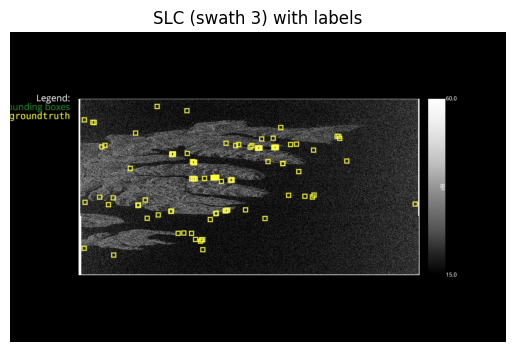

In [41]:
# PJM: Plot the last swath image inline using matplotlib
import matplotlib.pyplot as plt

img = plot_SLC.render()  # Capture the VisPy canvas as an image
plt.title("SLC (swath 3) with labels")
plt.imshow(img)
plt.axis('off')
plt.show()

## 7. How to train, validate and test the reference/baseline model

A baseline reference implementation of a real-valued deep learning model is provided for the purpose of introducing new users to training and validating, testing models on the SARFish SLC data in addition to illustrating the use of the SARFish metrics. The reference model demonstrates how to use the SARFish metrics during training, testing and evaluation to help inform the development of better performing models.

The baseline uses the predefined PyTorch implementation of FCOS; chosen because it uses the concept of “centre-ness”, which we believe is applicable to the maritime objects in this dataset.

The baseline can be trained and evaluated by sequentially running the following scripts:

1_create_tile.py generates the tiles used for training the baseline. Approximately 300GB is required for storage:

**The next cell creates the tiles (commented out). The next 7 cells are just basic QC of the first tile (and its mask) created that I've added.**

In [ ]:
#! ./1_create_tile_copy1.py # PJM: this version of create_tile.py just has extra error checking that I've added, basic functionality is unchanged

In [ ]:
# PJM: examine the first tile

import numpy as np

# Load a .npy file
images = np.load("0_0.npy")

# Check its shape. Each .npy has 4 channels, vh_mag, vh_phase, vv_mag, vv_phase
images.shape

In [ ]:
tile_nodata_mask = np.zeros((1024, 1024), dtype=bool)
tile_nodata_mask.shape

In [ ]:
print(tile_nodata_mask)

In [ ]:
img0 = images[0, :, :]
img0.shape

In [ ]:
img0_scaled = scale_sentinel_1_image(img0, tile_nodata_mask, product_type = "SLC")
img0_scaled_clipped = np.clip(img0_scaled, 10, 30)
plot_img0_scaled = SARFish_Plot(img0_scaled_clipped, tile_nodata_mask, title = f"img0", show=True)

In [ ]:
image = plot_img0_scaled.render()  # Capture the VisPy canvas as an image
plt.title("Tile (0,0): VH-polarisation, magnitude")
plt.imshow(image)
plt.axis('off')
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Initialize MinMaxScaler
scaler = MinMaxScaler()

# Create a figure with a 4x4 grid of subplots
fig, axes = plt.subplots(2, 2, figsize=(6, 6))

titles = ["VH mag", "VH phase", "VV mag", "VV phase"]

for i in range(4):
    img = images[i, :, :]
    ax = axes[i // 2, i % 2]  # Calculate row and column position
    #img_scaled = scale_sentinel_1_image(img, tile_nodata_mask, product_type = "SLC") # applies decibel scaling
    #img_scaled_clipped = np.clip(img_scaled, 10, 30) # clips the scaled image
    #img_scaled_clipped_norm = scaler.fit_transform(img_scaled_clipped)  # normalizes the scaled & clipped image
    #ax.imshow(img_scaled_clipped_norm, cmap='gray')  # displays image in grayscale
    img_norm = scaler.fit_transform(img)
    ax.set_title(titles[i], fontsize=10)
    ax.imshow(img_norm, cmap='gray')
    ax.axis('off')  # Hide axes
    plt.suptitle("Tile (0,0): Normalised images with no decibel scaling or clipping")

The following trains, validates and tests the baseline model n a small subset of the SARFish dataset detailed in fold.csv:

In [ ]:
# ! ./2_train.py
# ! ./3_test.py

4_evaluate.py calls the SARFish_metric.py script on the testing scenes to determine model peformance on the SARFish challenge 
tasks.

In [ ]:
# ! ./4_evaluate.py

The following scripts call the model over the entire public partition of the SARFish dataset to generate the submission/predictions uploaded to the Kaggle competition as the benchmark.

In [ ]:
# ! ./5_inference.py
# ! ./6_concatenate_scene_predictions.py

## 8. SARFish challenge prediction submission format

The following cell loads an simulated example of a set of predictions to illustrate the format of submissions for SLC product type in the SARFish challenge. Submissions for the challenge must have the following required columns. The predictions format (like the groundtruth labels) differs from the GRD by requiring a swath\_index column to specify which swath the prediction belongs to. 

**Things to note:**
- The Kaggle evalutation of submissions requires a dummy column named "Index" to work. 
- NaNs exist in the SARFish groundtruth labels where maritime object classification or length is unknown or not applicable, **however** the submission file must make a prediction for each of the columns in the submission format table to be valid. The operation of the SARFish metrics script means that maritime object classification and vessel length regression performance is only measured for detections in the submission file assigned to groundtruth for which the respective label exists.
- Predictions/submission will be evaluated on the entire public partition of the dataset. For a participant's prediction to be evaluated, they need to provide predictions in the correct format for each scene_id in the public partition.
- Each subsequent track is dependent on the one before it. For example: submissions to the vessel length regression track will need to first detect maritime objects, then classify vessels, and then estimate vessel length. Each Kaggle competition associated with a particular track will only evaluate that competiton's track, and same submission file may be submitted to each of the other tracks in the SARFIsh challenge. 

In [ ]:
reference_SLC_predictions_path = Path("labels", "reference_model", 
                                      "reference_predictions_SLC_validation_S1B_IW_SLC__1SDV_20200803T075720_20200803T075748_022756_02B2FF_E5D2.csv")
reference_SLC_predictions = pd.read_csv(str(reference_SLC_predictions_path))
reference_SLC_predictions.info()

Plotting the simulated SLC predictions.

In [ ]:
# for swath_index, plot_SLC in zip([1, 2, 3], SLC_plots):
#     swath_reference_SLC_predictions = reference_SLC_predictions[reference_SLC_predictions['swath_index'] == swath_index]
#     plot_SLC.add_labels(
#         columns = swath_reference_SLC_predictions['detect_scene_column'], rows = swath_reference_SLC_predictions['detect_scene_row'],
#         categories = swath_reference_SLC_predictions[['is_vessel', 'is_fishing']],
#         legend_label = "reference SLC predictions", color = "red"
#     )

## 9. How to evaluate model performance using the SARFish metric

The evaluation metrics for the SARFish is based on those from the xView3-SAR challenge. The provided SARFish\_metrics script takes into consideration the imaging geometry differences between the GRD and SLC products and makes comparing the detection, classification, and length regression results of models trained on the two product\_types straight-forward.

### 9.1 Maritime Object Detection Track

The maritime object detection track is comprised of the following tasks, which are directly comparable with those from the xView3 challenge. The overall maritime object detection score is the mean of the maritime object and close-to-shore object detection tasks:

$$maritime\_object\_detection\_score := \frac{(F1_D + F1_S)}{2}$$

#### Maritime Object Detection Task

The objective of this task is to find maritime objects in the SARFish imagery. The detection task is evaluated by assigning model predictions to the ground truth maritime object locations contained in the SARFish labels using the Hungarian matching algorithm. Model predictions within 200 meters of a 'HIGH' or 'MEDIUM' confidence ground truth are assigned as true positive detections. Successful models will have to localise maritime objects in full-size SARFish products and distinguish them from sea-clutter, small-islands and SAR ambiguities. Performance on this task is quantified over all the relevant maritime objects in the public partition using an [F1-score](https://en.wikipedia.org/wiki/F-score) denoted: 

$$F 1_D$$

The F1 score is defined as:

$$F_{1} := \frac{2}{1/precision + 1/recall}$$

where recall and precision are defined as:

$$precision := \frac{True\_Positives}{True\_Positives + False\_Positives}$$
$$recall := \frac{True\_Positives}{Positives}$$

#### Close-to-Shore Object Detection Task

The Close-to-Shore detection task is a subset of the maritime detection task. This task is evaluated by assigning model predictions to “HIGH” or “MEDIUM” confidence ground truth within 2 000 meters of the shoreline. The SARFish dataset provides two shorelines for evaluation of the Close-to-Shore task. The challenge will utilise the xView3 shoreline in order for the results to be directly comparable with the xView3 challenge. Close-to-Shore detection is a particularly challenging task whereby successful models will have to distinguish maritime objects from land objects with intense radar returns in addition to the challenges posed by standard maritime object detection. Performance on this task is quantified by the F1-score:

 $$F1_S$$

### 9.2 Maritime Object Classification Track

The maritime object classification track consists of two hierarchical classification tasks. These have also been chosen to be directly comparable with those in the xView3 challenge. The overall maritime object classification score is the mean of the vessel classification and fishing vessel classification tasks:

$$Maritime\\_object\\_classification\\_score := \frac{(F1_V + F1_F)}{2}$$

### Vessel Classification Task

The objective of this task is: given a maritime object has been detected, distinguish whether it is a vessel or not. This task is evaluated only on the true positive predictions from the overall maritime detection task, and on ground truth detections for which a True or False “is vessel” label is available. Successful models will have to distinguish between non-vessel maritime objects such as oil-rigs and offshore wind farm turbines and vessels such as oil-tankers and container ships. Performance on this task is quantified by an [F1-score](https://en.wikipedia.org/wiki/F-score) denoted:

 $$F 1_V$$

### Fishing Classification Task

This task is dependent on the results of the vessel classification task. The objective of this task is: given a maritime object has been detected, and the maritime object has been correctly classified as a vessel, distinguish whether or not it is a fishing or non-fishing vessel. This task is evaluated on the true positive classifications from the vessel classification task, and only on the ground truth for which the “is vessel” label is True or False. Successful models will have to distinguish subtle differences such as those between large fishing vessels and small cargo vessels. Performance on this task is quantified by the F1-score:

$$F 1_F$$

### 9.3 Vessel Length Regression Track

The Vessel Length Regression Track is taken directly from the Percentage Error metric of the Vessel Length Estimation task of the xView3-SAR Challenge. The metric actually expresses an accuracy, but we will stick with the xView3 notation for consistency.

The objective of this task is to accurately predict the length of vessels in the SARFish imagery. The task is evaluated on the true positive detections from the maritime object detection task and only on ground truth for which a vessel length label exists. We note that the correct estimation of the length of maritime objects is a crucial factor that may increase the performance of classification methods, as the length of a vessel alone is a powerful feature for the classifying different types of maritime objects. Successful models will have to overcome challenging SAR artefacts associated with high intensity radar returns from metal-hulled ships such as side-lobing, smearing and multi-path effects. Performance on this task is quantified by the aggregate percentage accuracy (erroneously called the aggregate percentage error in the xView3-SAR challenge) which penalises a prediction equally for over or underestimating vessel length. The accuracy used in this task is defined as:

$$PE_L = 1 - min \Big(\frac{1}{N}\frac{| min(\hat{l}_n, l_m) \ - \ min(l_n, l_m) |}{min(\hat{l}_n, l_m)}, 1\Big)$$

**Note** we still use the xView3 notation for the accuracy even though it was erroneously called an error.

Where:
predicted vessel length is:

$$\hat{l}$$

actual vessel length is:

$$l$$

upper bound for vessel length prediction is:

$$l_m$$

### 9.4 SARFish metric parameters

#### str: shoreline\_type ["xView3\_shoreline", "global\_shoreline\_vector"] - default "xView3\_shoreline"

The type of shoreline vector to use for the evaluation of the close-to-shore detection task. The choices are:
    - "xView3\_shoreline" which are the xView3-SAR dataset shorelines projected into the pixel space of the GRD and SLC SARFish products. This shoreline allows a one to one comparison between the performance of models trained using the xView3-SAR imagery and SARFish imagery on the close-to-shore detection task.
    - "global\_shoreline\_vector" derived from the [GlobalIslands global shoreline vector](https://www.tandfonline.com/doi/full/10.1080/1755876X.2018.1529714). This shoreline is an update to the shorelines using a more accurate source. [3]

#### float: distance\_from\_shore\_tolerance\_meters - default: 2000.0

The tolerance used to designate a prediction and groundtruth as close-to-shore. This tolerance is used to pick out a subset of the predicitions and groundtruth for evaluating the close-to-shore detection task.

#### float: assignment\_tolerance\_meters - default: 200.0

The tolerance used to threshold assignments between prediction and groundtruth detections as true positives. As a default any assignment between prediction and groundtruth under 200.0 meters distance apart is counted as a true positive for that particular detection task. This tolerance is also used in the determinination of the predictions asocciated with low confidence groundtruth if the *score\_all* flag is False AND the *drop_\low\_detect* flag is True.

#### float: score\_all - default: False

Whether to score the predictions against all groundtruth label confidence levels. By default the score function drops groundtruth for which the "confidence" attribute is "LOW" and evaluates model performance against "MEDIUM" and "HIGH" confidence groundtruth only.

#### bool: drop\_low\_detect - default: True

Whether to use the Hungarian matching algorithm the find the lowest distance cost assignment of predictions to the "LOW" confidence groundtruth and remove them from further consideration in the metrics. This option is used in concert with *score\_all* = False, and means that when evaluating the performance of the predictions against "MEDIUM" and "HIGH" confidence groundtruth only, an unfair penalty  is not inccurred for correctly detecting maritime objects with a confidence attribute of "LOW".

#### costly\_dist - default: True

Whether to assign a very large distance to pairwise distances between predictions and groundtruth when the distance is larger than the *assignment\_tolerance\_meters* threshold for true positive assignment. This modifies the optimisation problem solved by the Hungarian matching algorithm and means that predictions and groundtruth with a pairwise distances larger than the threshold are unlikely to be assigned to each other. Without this option the matching algorithm may find low cost solutions which associate more groundtruth and predictions further apart than the threshold than otherwise, and may increase the false positive and false negative count.

[3] R. Sayre et al., “A new 30 meter resolution global shoreline vector and associated global islands database for the development of standardized ecological coastal units,” Journal of Operational Oceanography, vol. 12, no. sup2, pp. S47–S56, 2019. Downloaded from https://www.sciencebase.gov/catalog/item/63bdf25dd34e92aad3cda273 at https://www.sciencebase.gov/catalog/file/get/63bdf25dd34e92aad3cda273

### 9.5 GRD metric evaluation

The following cell shows an example of calling the SARFish\_metric.score function on the simulated predictions for a single scene.s

In [ ]:
# score(
#     predictions = reference_GRD_predictions, groundtruth = groundtruth_GRD, 
#     xView3_SLC_GRD_correspondences = xView3_SLC_GRD_correspondences, SARFish_root_directory = SARFish_root_directory, 
#     product_type = "GRD", shoreline_type = "xView3_shoreline", 
#     score_all =  False, drop_low_detect = True, costly_dist = True, evaluation_mode = False
# )

### 9.6 SLC metric evaluation

The evaluation of predictions on an SLC product is straight-forward. The metrics script handles the multiple swaths and imaging geometry of the SLC products. The script transforms the pixel indices into distances of meters to evaluate the detection tasks in the same units as the xView3-SAR data.

In [ ]:
score(
    predictions = reference_SLC_predictions, groundtruth = groundtruth_SLC, 
    xView3_SLC_GRD_correspondences = xView3_SLC_GRD_correspondences, 
    SARFish_root_directory = SARFish_root_directory, product_type = "SLC", 
    shoreline_type = "xView3_shoreline", score_all =  False, drop_low_detect = True, 
    costly_dist = False, evaluation_mode = False
)

The following cell illustrates how to run the SARFish metric script from the command line.

In [ ]:
! ./SARFish_metric.py \
    -p labels/reference_model/reference_predictions_SLC_validation_S1B_IW_SLC__1SDV_20200803T075720_20200803T075748_022756_02B2FF_E5D2.csv \
    -g "${SARFISH_ROOT_DIRECTORY}"/SLC/validation/SLC_validation.csv \
    --sarfish_root_directory "${SARFISH_ROOT_DIRECTORY}" \
    --product_type SLC \
    --xview3_slc_grd_correspondences labels/xView3_SLC_GRD_correspondences.csv \
    --shore_type xView3_shoreline \
    --no-evaluation_mode